# Estimator validation

This notebook contains code to generate Figure 2 of the paper. 

This notebook also serves to compare the estimates of the re-implemented scmemo with sceb package from Vasilis. 


In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import scanpy as sc
import scipy as sp
import itertools
import numpy as np
import scipy.stats as stats
from scipy.integrate import dblquad
import seaborn as sns
from statsmodels.stats.multitest import fdrcorrection
import imp
pd.options.display.max_rows = 999
pd.set_option('display.max_colwidth', -1)
import pickle as pkl
import time

/tmp/ipykernel_17826/1565241514.py:13: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  pd.set_option('display.max_colwidth', -1)


In [2]:
import matplotlib as mpl
mpl.rcParams['pdf.fonttype'] = 42
mpl.rcParams['ps.fonttype'] = 42

import matplotlib.pylab as pylab
params = {'legend.fontsize': 'x-small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'xx-small',
         'ytick.labelsize':'xx-small'}
pylab.rcParams.update(params)


In [3]:
import sys
sys.path.append('/home/ssm-user/Github/scrna-parameter-estimation/dist/memento-0.0.9-py3.8.egg')
import memento
import memento.simulate as simulate

In [4]:
# import sys
# sys.path.append('/home/ssm-user/Github/single_cell_eb/')
# sys.path.append('/home/ssm-user/Github/single_cell_eb/sceb/')
# import scdd

In [5]:
data_path = '/data_volume/memento/demux/'
fig_path = '/data/home/Github/scrna-parameter-estimation/figures/fig3/'

### Extract parameters from interferon dataset

In [6]:
adata = sc.read(data_path + 'interferon_filtered.h5ad')
adata = adata[adata.obs.cell_type == 'CD4 T cells - ctrl']
data = adata.X.copy()
relative_data = data.toarray()/data.sum(axis=1)

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:1095: FutureWarning: The `inplace` parameter in pandas.Categorical.remove_unused_categories is deprecated and will be removed in a future version.
  df_sub[k].cat.remove_unused_categories(inplace=True)


In [7]:
q = 0.07
x_param, z_param, Nc, good_idx = memento.simulate.extract_parameters(adata.X, q=q, min_mean=q)

### Comparison function

In [14]:
def compare_esimators(q, plot=False, true_data=None, var_q=1e-10):
    
    q_sq = var_q + q**2
    
    true_data = memento.simulate.simulate_transcriptomes(1000, 1000, correlated=True) if true_data is None else true_data
    true_relative_data = true_data / true_data.sum(axis=1).reshape(-1, 1)

    qs, captured_data = memento.simulate.capture_sampling(true_data, q, q_sq)
    Nr = captured_data.sum(axis=1).mean()
    captured_relative_data = captured_data/captured_data.sum(axis=1).reshape(-1, 1)
    adata = sc.AnnData(sp.sparse.csr_matrix(captured_data))
    adata.write('/data_volume/memento/simulation/estimation/estimation_{}.h5ad'.format(q))
    sf = memento.estimator._estimate_size_factor(adata.X, 'hyper_relative', total=True, shrinkage=0.0)

    good_idx = (captured_data.mean(axis=0) > q)

    # True moments
    m_true, v_true, corr_true = true_relative_data.mean(axis=0), true_relative_data.var(axis=0), np.corrcoef(true_relative_data, rowvar=False)
    rv_true = v_true/m_true**2#memento.estimator._residual_variance(m_true, v_true, memento.estimator._fit_mv_regressor(m_true, v_true))
    
    # Compute 1D moments
    m_obs, v_obs = captured_relative_data.mean(axis=0), captured_relative_data.var(axis=0)
    rv_obs = v_obs/m_obs**2#memento.estimator._residual_variance(m_obs, v_obs, memento.estimator._fit_mv_regressor(m_obs, v_obs))
    m_poi, v_poi = memento.estimator._poisson_1d_relative(adata.X, size_factor=sf, n_obs=true_data.shape[0])
    rv_poi = v_poi/m_poi**2#memento.estimator._residual_variance(m_poi, v_poi, memento.estimator._fit_mv_regressor(m_poi, v_poi))
    m_hyp, v_hyp = memento.estimator._hyper_1d_relative(adata.X, size_factor=sf, n_obs=true_data.shape[0], q=q)
    rv_hyp = v_hyp/m_hyp**2#memento.estimator._residual_variance(m_hyp, v_hyp, memento.estimator._fit_mv_regressor(m_hyp, v_hyp))

    # Compute 2D moments
    corr_obs = np.corrcoef(captured_relative_data, rowvar=False)
#     corr_obs = corr_obs[np.triu_indices(corr_obs.shape[0])]
        
    idx1 = np.array([i for i,j in itertools.combinations(range(adata.shape[1]), 2) if good_idx[i] and good_idx[j]])
    idx2 = np.array([j for i,j in itertools.combinations(range(adata.shape[1]), 2) if good_idx[i] and good_idx[j]])
    sample_idx = np.random.choice(idx1.shape[0], 10000)
    
    idx1 = idx1[sample_idx]
    idx2 = idx2[sample_idx]

    corr_true = corr_true[(idx1, idx2)]
    corr_obs = corr_obs[(idx1, idx2)]
    
    cov_poi = memento.estimator._poisson_cov_relative(adata.X, n_obs=adata.shape[0], size_factor=sf, idx1=idx1, idx2=idx2)
    cov_hyp = memento.estimator._hyper_cov_relative(adata.X, n_obs=adata.shape[0], size_factor=sf, idx1=idx1, idx2=idx2, q=q)
    corr_poi = memento.estimator._corr_from_cov(cov_poi, v_poi[idx1], v_poi[idx2])
    corr_hyp = memento.estimator._corr_from_cov(cov_hyp, v_hyp[idx1], v_hyp[idx2])

    corr_poi[np.abs(corr_poi) > 1] = np.nan
    corr_hyp[np.abs(corr_hyp) > 1] = np.nan

    mean_list = [m_obs, m_poi, m_hyp]
    var_list = [rv_obs, rv_poi, rv_hyp]
    corr_list = [corr_obs, corr_poi, corr_hyp]
    estimated_list = [mean_list, var_list, corr_list]
    true_list = [m_true, rv_true, corr_true]

    if plot:
        count = 0
        for j in range(3):
            for i in range(3):

                plt.subplot(3, 3, count+1)


                if i != 2:
                    plt.scatter(
                        np.log(true_list[i][good_idx]),
                        np.log(estimated_list[i][j][good_idx]),
                        s=0.1)
                    plt.plot(np.log(true_list[i][good_idx]), np.log(true_list[i][good_idx]), linestyle='--', color='m')
                    plt.xlim(np.log(true_list[i][good_idx]).min(), np.log(true_list[i][good_idx]).max())
                    plt.ylim(np.log(true_list[i][good_idx]).min(), np.log(true_list[i][good_idx]).max())

                else:

                    x = true_list[i]
                    y = estimated_list[i][j]
                    
                    print(x.shape, y.shape)

                    plt.scatter(
                        x,
                        y,
                        s=0.1)
                    plt.plot([-1, 1], [-1, 1],linestyle='--', color='m')
                    plt.xlim(-1, 1);
                    plt.ylim(-1, 1);
                    
#                 if not (i == j):
#                     plt.yticks([]);
#                     plt.xticks([]);
                    
                if i == 1 or i == 0:
                    
                    print((np.log(true_list[i][good_idx]) > np.log(estimated_list[i][j][good_idx])).mean())

                count += 1
    else:
        return qs, good_idx, estimated_list, true_list

### Concordance

In [15]:
true_data = memento.simulate.simulate_transcriptomes(n_cells=10000, means=z_param[0], variances=z_param[1], Nc=Nc)

In [16]:
sc.AnnData(X=true_data, obs=pd.DataFrame(index=np.arange(10000)), var=pd.DataFrame(index=np.arange(true_data.shape[1])))\
    .write('/data_volume/memento/simulation/estimation/estimation.h5ad')

/home/ssm-user/anaconda3/envs/single_cell/lib/python3.8/site-packages/anndata/_core/anndata.py:119: ImplicitModificationWarning: Transforming to str index.
  warnings.warn("Transforming to str index.", ImplicitModificationWarning)


In [17]:
def compute_mse(x, y, log=True):
    
    if log:
        return np.nanmean(np.abs(np.log(x)-np.log(y)))
    else:
        return np.nanmean(np.abs(x-y))

def concordance(x, y, log=True):
    
    if log:
        a = np.log(x)
        b = np.log(y)
    else:
        a = x
        b = y
    cond = np.isfinite(a) & np.isfinite(b)
    a = a[cond]
    b = b[cond]
    cmat = np.cov(a, b)
    return 2*cmat[0,1]/(cmat[0,0] + cmat[1,1] + (a.mean()-b.mean())**2)
    
m_mse_list, v_mse_list, c_mse_list = [], [], []
# true_data = memento.simulate.simulate_transcriptomes(n_cells=10000, means=z_param[0], variances=z_param[1],
#     Nc=Nc)
q_list = [0.01, 0.025, 0.05, 0.1, 0.15, 0.2, 0.25, 0.35, 0.5]
qs_list = []
for q in q_list:
    qs, good_idx, est, true = compare_esimators(q, plot=False, true_data=true_data)
    qs_list.append(qs)
    m_mse_list.append([concordance(x[good_idx], true[0][good_idx]) for x in est[0]])
    v_mse_list.append([concordance(x[good_idx], true[1][good_idx])  for x in est[1]])
    c_mse_list.append([concordance(x, true[2], log=False) for x in est[2]])
    
m_mse_list, v_mse_list, c_mse_list = np.array(m_mse_list), np.array(v_mse_list), np.array(c_mse_list)

/tmp/ipykernel_17826/4294624721.py:11: RuntimeWarning: invalid value encountered in log
  a = np.log(x)


In [12]:
techs = {
    '10x_v1':0.08/2,
    '10x_v2':0.15/2,
    '10x_v3':0.32/2,
    'Smart-seq3':0.68/2
}

(0.15, 1.05)

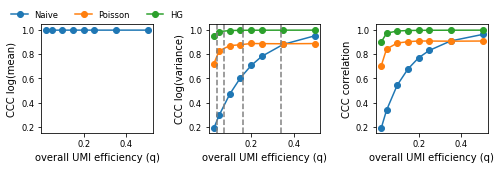

In [13]:
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'small',
         'axes.labelsize': 'medium',
         'axes.titlesize':'medium',
         'figure.titlesize':'medium',
         'xtick.labelsize':'small',
         'ytick.labelsize':'small'}
pylab.rcParams.update(params)

plt.figure(figsize=(8, 2))
plt.subplots_adjust(wspace=0.5)

plt.subplot(1, 3, 1)
plt.plot(q_list[1:], m_mse_list[:, 0][1:], '-o')
# plt.legend(['Naive,\nPoisson,\nHG'])
plt.ylabel('CCC log(mean)')
plt.xlabel('overall UMI efficiency (q)')
plt.ylim(0.15, 1.05)

start = 1
plt.subplot(1, 3, 2)
plt.plot(q_list[start:], v_mse_list[:, 0][start:], '-o')
plt.plot(q_list[start:], v_mse_list[:, 1][start:], '-o')
plt.plot(q_list[start:], v_mse_list[:, 2][start:], '-o')

for tech, capture in techs.items():
    plt.plot([capture, capture], [0.15, 1.05], '--', color='grey')

plt.legend(['Naive', 'Poisson', 'HG'], ncol=3, loc='upper center', bbox_to_anchor=(-1,1.2), frameon=False)
plt.ylabel('CCC log(variance)')
plt.xlabel('overall UMI efficiency (q)')
plt.ylim(0.15, 1.05)


plt.subplot(1, 3, 3)
plt.plot(q_list[start:], c_mse_list[:, 0][start:], '-o')
plt.plot(q_list[start:], c_mse_list[:, 1][start:], '-o')
plt.plot(q_list[start:], c_mse_list[:, 2][start:], '-o')
# plt.legend(['Naive', 'Poisson', 'HG'])
plt.ylabel('CCC correlation')
plt.xlabel('overall UMI efficiency (q)')
plt.ylim(0.15, 1.05)


# plt.savefig('estimation_efficiencies.pdf', bbox_inches='tight')